In [1]:
import pandas as pd
from pathlib import Path
import pgeon.policy_graph as PG
from example.environment import SelfDrivingEnvironment
from nuscenes import NuScenes
import numpy as np
from matplotlib.patches import Rectangle

from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from example.discretizer.discretizer import AVDiscretizer
import math
from typing import Tuple

from example.dataset.utils import create_rotated_rectangle
import matplotlib.pyplot as plt

In [2]:
#path where you stored the copy of the nuScenes dataset.
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/dataset/data/sets/nuscenes')

#MINI
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'yaw_rate': 'float64'}
df = pd.read_csv(DATAROOT / 'test_v1.0-trainval_lidar_0.csv', dtype=dtype_dict, parse_dates=['timestamp'])
#df['detect_CAM_FRONT'] = df['detect_CAM_FRONT'].apply(lambda x: ast.literal_eval(x))
#df['detect_CAM_BACK'] = df['detect_CAM_BACK'].apply(lambda x: ast.literal_eval(x))
city ='boston-seaport'#'singapore-hollandvillage' # 'boston-seaport' #'boston-seaport'#'singapore-onenorth' boston-seaport'#
df = df[df['location'] == city]
df.head()

,sample_token,scene_token,steering_angle,location,modality,timestamp,rotation,x,y,z,yaw,velocity,yaw_rate,acceleration
0,1f757389dc2745baadc043c284e16881,010fb5bcc7984d0f8f07f99e02366df1,-0.010400,boston-seaport,lidar,2018-09-18 17:00:41.549530,"[-0.27173179384525814, 0.0013722930372376749, ...",911.767081,1320.845574,0.0,2.591214,9.136557,-0.002927,0.000000
1,d64538ac461b466eab383cdfac23f246,010fb5bcc7984d0f8f07f99e02366df1,-0.010400,boston-seaport,lidar,2018-09-18 17:00:42.048827,"[-0.27242824971745977, -0.0014603266491040553,...",907.897200,1323.261055,0.0,2.589753,9.136557,-0.002927,0.000000
2,575f4befe1a2400b91b0785d11f41e0c,010fb5bcc7984d0f8f07f99e02366df1,-0.010400,boston-seaport,lidar,2018-09-18 17:00:42.548725,"[-0.2740640513555559, 0.00011259131003696484, ...",904.008347,1325.703459,0.0,2.586364,9.186320,-0.006780,0.099547
3,17f1bbb6562648e49a223f22dfd9d98c,010fb5bcc7984d0f8f07f99e02366df1,-0.010400,boston-seaport,lidar,2018-09-18 17:00:42.948499,"[-0.27434698798642815, 0.0003687943052606993, ...",900.872508,1327.680458,0.0,2.585772,9.272795,-0.001481,0.216308
4,17706c1ad2f742d899dbb58243fbaf94,010fb5bcc7984d0f8f07f99e02366df1,0.003563,boston-seaport,lidar,2018-09-18 17:00:43.448386,"[-0.2746760449535556, 0.006740671131163572, -0...",896.937268,1330.154191,0.0,2.585168,9.298437,-0.001208,0.051297


Fit PG

In [4]:
env = SelfDrivingEnvironment(city)

In [5]:

#disc = AVDiscretizer(env)
#pg = PG.PolicyGraph(env, disc)
#pg = pg.fit(df, update=False, verbose=True)

Render

In [6]:
nusc_map = NuScenesMap(dataroot='example/dataset/data/sets/nuscenes', map_name = city)

In [7]:
scene_test = '5c76a3728b8b4d02ae20bd69fb928aa1' #df['scene_token'].unique()[0] 
example_scene_df = df[df['scene_token']==scene_test]

In [8]:

ego_poses = nusc_map.render_egoposes_on_fancy_map(nuscenes, scene_tokens=['40209c4e465d4b4e8341ebd52be0d842'], verbose=False)


NameError: name 'nuscenes' is not defined

In [ ]:
#nuscenes.render_scene(scene_test)

### Test Lane Progress Discretization

In [ ]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']==scene]
    print(f'SCENE {scene}')
    for i in range(example_scene_df.shape[0]):
        
        x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
        
        lane_predicates = env.get_lane_info(x,y, yaw, eps=0.3, agent_size=(2,4))
        print(lane_predicates)
        if False:########
            #PLOT
            ########
            
            #render agent as a renctangle and show its heading direction compare to the direction of the lane
            #for each sample in the scene.
            road_segment_token = nusc_map.record_on_point(x,y, 'road_segment')
            current_lane = nusc_map.record_on_point(x,y, 'lane')

            if road_segment_token and nusc_map.get('road_segment', road_segment_token)['is_intersection'] and not current_lane:
                closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
                lane_path = nusc_map.get_arcline_path(closest_lane)
                closest_pose_idx_to_lane, lane_record, _ = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane_path)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                    tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

            else:

                lane = nusc_map.get_arcline_path(current_lane)
                closest_pose_idx_to_lane, lane_record, distance_along_lane = SelfDrivingEnvironment.project_pose_to_lane((x, y, yaw), lane)
                if closest_pose_idx_to_lane == len(lane_record) - 1:
                        tangent_vector = lane_record[closest_pose_idx_to_lane] - lane_record[closest_pose_idx_to_lane - 1]
                else:
                    tangent_vector = lane_record[closest_pose_idx_to_lane + 1] - lane_record[closest_pose_idx_to_lane]

    
              
            patch_size = 20
            patch_box = [x,y, patch_size, patch_size]
            patch = NuScenesMapExplorer.get_patch_coord(patch_box)
            minx, miny, maxx, maxy = patch.bounds

            fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
            
            #ax.add_patch(Rectangle((x, y), agent_size[0], agent_size[1], yaw))
            ax.scatter(x,y)
            heading_vector = np.array([np.cos(yaw), np.sin(yaw)])

            yaw =  math.degrees(-(math.pi / 2) + yaw)
            rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
            ax.quiver(x, y, heading_vector[0], heading_vector[1], color='b', scale=10, label='Ego Direction')
            ax.quiver(x,y, tangent_vector[0], tangent_vector[1],  color='r', scale=10, label='Lane Direction')
            x,y = rotated_rectangle.exterior.xy
            ax.plot(x,y)
            ax.set_title(lane_predicates)
            
    print('-------------------------')

In [ ]:
for i in range(example_scene_df.shape[0]):
    x,y,yaw = example_scene_df.iloc[i][['x','y', 'yaw']].tolist()
    yaw =  math.degrees(-(math.pi / 2) + yaw)
    if True:#is_on_divider(x,y,yaw, (2,4), ['road_divider', 'lane_divider']) in [True]:

         #for visual confirmation
        patch_size = 20
        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds

        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], ['road_divider', 'lane_divider'], figsize=(5, 5))
        
        ax.scatter(x,y)

        rotated_rectangle = create_rotated_rectangle((x,y), yaw, (2,4))
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y)
    
        plt.title(f'Plot for index {i}')
        plt.show()


### Test Stop Line Discretization

In [9]:
#VERSION RADIUS

def is_near_traffic_light( x,y, radius:float=30):
        """
        Check if there is a traffic light nearby the given pose (x, y).

        Args:
            x (float): Current x-coordinate of the vehicle.
            y (float): Current y-coordinate of the vehicle.

        Returns:
            True or False (TODO return dict: Information about the nearby traffic light (if any))
        """
        current_road_block = nusc_map.record_on_point(x, y, 'road_block') 

        if current_road_block: #check if road 
            for traffic_light in nusc_map.traffic_light:
                road_block_affected = traffic_light['from_road_block_token']              

                if road_block_affected == current_road_block:
                    traffic_light_x = traffic_light['pose']['tx']
                    traffic_light_y = traffic_light['pose']['ty']
                    distance = np.sqrt((x - traffic_light_x)**2 + (y - traffic_light_y)**2)
                    
                    if distance <=radius:
                        
                        return True#self.get_traffic_light_status(traffic_light)
        else:
            road_segment_token = nusc_map.record_on_point(x,y, 'road_segment')
            is_intersection = nusc_map.get('road_segment', road_segment_token)['is_intersection']
            
            if is_intersection:
                for traffic_light in nusc_map.traffic_light:
                    traffic_light_x = traffic_light['pose']['tx']
                    traffic_light_y = traffic_light['pose']['ty']
                    distance = np.sqrt((x - traffic_light_x)**2 + (y - traffic_light_y)**2)
                        
                        #print(distance)
                    if distance <=radius/2:
                            
                        return True#self.get_traffic_light_status(traffic_light)
     
        return False




In [36]:
from shapely import affinity
from shapely.geometry import Polygon
def create_rotated_rectangle(center, yaw, size, shift_forward=5.0):
    """
    Create a rotated rectangle as a Shapely Polygon with an option to shift its center forward.

    :param center (tuple): (x, y) coordinates of the rectangle's center.
    :param yaw (float): Rotation angle in degrees.
    :param size (tuple): (width, height) of the rectangle's size.
    :param shift_forward (float): Amount to shift the center forward in meters.

    :return Polygon: A Shapely Polygon representing the rotated rectangle.
    """
    x, y = center
    width, height = size

    # Convert yaw to radians for Shapely's rotate function
    yaw_rad = math.radians(yaw)

    # Calculate the shift vector based on the yaw angle
    shift_x = shift_forward * math.cos(yaw_rad)
    shift_y = shift_forward * math.sin(yaw_rad)

    # Adjust the center coordinates
    x_shifted = x + shift_x
    y_shifted = y #+ shift_y

    # Define the rectangle vertices
    rectangle = Polygon([
        (x_shifted - width / 2, y_shifted - height / 2),
        (x_shifted + width / 2, y_shifted - height / 2),
        (x_shifted + width / 2, y_shifted + height / 2),
        (x_shifted - width / 2, y_shifted + height / 2)
    ])

    # Rotate the rectangle around its center
    rotated_rectangle = affinity.rotate(rectangle, yaw, origin='center', use_radians=False)

    return rotated_rectangle

In [37]:
def render_ego_on_patch(x,y,yaw, patch_size=20, non_geometric_layers=['road_divider', 'lane_divider'], agent_size = (2,4)):

        patch_box = [x,y, patch_size, patch_size]
        patch = NuScenesMapExplorer.get_patch_coord(patch_box)
        minx, miny, maxx, maxy = patch.bounds
        
        fig, ax = nusc_map.render_map_patch( [minx, miny, maxx, maxy], non_geometric_layers, figsize=(5, 5))
            
        ax.scatter(x,y)
        yaw =  math.degrees(-(math.pi / 2) + yaw)
        rotated_rectangle = create_rotated_rectangle((x,y), yaw,agent_size)
        x,y = rotated_rectangle.exterior.xy
        ax.plot(x,y,linewidth=0.2)
        

        # Plot the heading vector
        #ax.quiver(x, y, heading_vector[0], heading_vector[1], color='r', scale=5, label='Ego direction')

        # Plot the tangent vector
        #closest_point = lane_record[closest_pose_idx_to_lane]
        #ax.quiver(closest_point[0], closest_point[1], tangent_vector[0], tangent_vector[1], color='b', scale=5, label='Lane direction')
        #ax.legend()

        plt.title('Plot for ego vehicle direction')
        plt.show()   
    

In [38]:
#VERSION BOX
from shapely.geometry import Point

from example.dataset.utils import  determine_travel_alignment
def is_near_traffic_light( x,y, yaw, box_size=(8,30)):
        """
        Check if there is a traffic light nearby the given pose (x, y).

        Args:
            x (float): Current x-coordinate of the vehicle.
            y (float): Current y-coordinate of the vehicle.


        Returns:
            True or False (TODO return dict: Information about the nearby traffic light (if any))
        """
        yaw_in_deg =  math.degrees(-(math.pi / 2) + yaw)
        rotated_rectangle = create_rotated_rectangle((x,y), yaw_in_deg, box_size)
        render_ego_on_patch(x,y,yaw, patch_size=50, non_geometric_layers=['road_divider', 'lane_divider', 'traffic_light', 'road_block','road_segment'], agent_size=box_size)
        
        for traffic_light in nusc_map.traffic_light:
                line = nusc_map.extract_line(traffic_light['line_token'])
                if line.is_empty:  # Skip lines without nodes
                    continue
                xs, ys = line.xy
                point = Point(xs[0], ys[0]) #Traffic light is represent as line, we take the starting point
                if point.within(rotated_rectangle):
                    traffic_light_direction = (xs[1] - xs[0], ys[1] - ys[0])
                    alignment = determine_travel_alignment(traffic_light_direction, yaw)
                    eps = 0.5
                    if alignment <-eps:
                        return True
                
        return False




SCENE 010fb5bcc7984d0f8f07f99e02366df1


/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/saramontese/.local/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


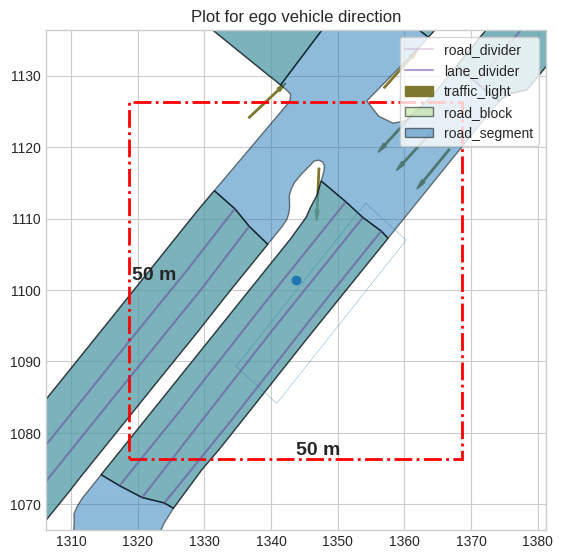

False


In [39]:
for scene in df['scene_token'].unique():#['295c6c85275e4376bc8446b4a76504cd']:#
    example_scene_df = df[df['scene_token']=='40209c4e465d4b4e8341ebd52be0d842']
    print(f'SCENE {scene}')
    for i in range(example_scene_df.shape[0]):
        x,y,yaw = example_scene_df.iloc[i][['x','y','yaw']].tolist()
        lane_predicates = is_near_traffic_light( x,y,yaw)
        print(lane_predicates)
        break
    break

In [ ]:
#nuscenes.render_scene(scene)

In [ ]:
def is_on_divider(self, x,y, yaw, agent_size:Tuple[float, float]) -> bool:
        """
        Checks whether the ego vehicle interescts stop line.
        :param x,y,yaw: coordinates (in meters) and heading (in radians) of the agent 
        :param agent_size: height and width of the box representing the agent
        :return: True if agent intersects the layers specified in layer_name
        """
        yaw =  math.degrees(-(math.pi / 2) + yaw)
        
        # rectangle centered at (x, y) and rotated of yaw angle representing the agent
        rotated_rectangle = create_rotated_rectangle((x,y), yaw, agent_size)

        for record in self.dividers:
            line = self.nusc_map.extract_line(record['line_token'])
            if line.is_empty:  # Skip lines without nodes.
                continue

            new_line = rotated_rectangle.intersection(line)
            if not new_line.is_empty:
                return True

        return False  